In [1]:
import pandas as pd
import seaborn.objects as so
from types import SimpleNamespace

In [2]:
class Table:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, transforms):
        if not isinstance(transforms, (tuple, list)):
            transforms = [transforms]

        table = self.data
        for transform in transforms:
            table = table.pipe(transform)

        return Table(table)

    def __repr__(self):
        return self.data.__repr__()

    def _repr_html_(self):
        return self.data._repr_html_()

In [3]:
def _count(*column_names):
    column_names = list(column_names)

    def inner(table):
        return table.value_counts(column_names).reset_index(name="count")

    return inner

In [4]:
def _mutate(funcs):
    def inner(table):
        return table.assign(**funcs)

    return inner

In [5]:
def _rollup(funcs):
    def inner(table):
        return pd.DataFrame(
            {name: pd.Series(func(table)) for name, func in funcs.items()}
        )

    return inner

In [6]:
def _sort(*column_names, reverse=False):
    column_names = list(column_names)
    ascending = not reverse

    def inner(table):
        return table.sort_values(by=column_names, ascending=ascending)

    return inner

In [7]:
def _filter(func):
    def inner(table):
        return table[func]

    return inner

In [8]:
def _slice(*args, **kwargs):
    to_slice = slice(5)

    if args or kwargs:
        to_slice = slice(*args, **kwargs)

    def inner(table):
        return table[to_slice]

    return inner

In [9]:
op = SimpleNamespace(
    Table=Table,
    count=_count,
    mutate=_mutate,
    rollup=_rollup,
    sort=_sort,
    filter=_filter,
    slice=_slice,
)

In [10]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-28/penguins.csv"
penguins = op.Table(pd.read_csv(url))

In [11]:
penguins[op.count("species")]

,species,count
0,Adelie,152
1,Gentoo,124
2,Chinstrap,68


In [12]:
penguins[op.count("island")]

,island,count
0,Biscoe,168
1,Dream,124
2,Torgersen,52


In [13]:
penguins[op.count("species", "island")]

,species,island,count
0,Gentoo,Biscoe,124
1,Chinstrap,Dream,68
2,Adelie,Dream,56
3,Adelie,Torgersen,52
4,Adelie,Biscoe,44


In [14]:
penguins[
    op.mutate({"upper_species": lambda t: t["species"].str.upper()})
]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,upper_species
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,ADELIE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,ADELIE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,ADELIE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007,ADELIE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,ADELIE
...,...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009,CHINSTRAP
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009,CHINSTRAP
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009,CHINSTRAP
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009,CHINSTRAP


In [15]:
penguins[
    op.mutate({
        "species": lambda t: t["species"].str.upper(),
        "island": lambda t: t["island"].str.upper(),
    }),
    op.count("species", "island"),
]

,species,island,count
0,GENTOO,BISCOE,124
1,CHINSTRAP,DREAM,68
2,ADELIE,DREAM,56
3,ADELIE,TORGERSEN,52
4,ADELIE,BISCOE,44


In [16]:
penguins[
    op.count("species"),
    op.sort("count", reverse=True),
]

,species,count
0,Adelie,152
1,Gentoo,124
2,Chinstrap,68


In [17]:
penguins[
    op.sort("island", "species"),
    op.slice(),
]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
20,Adelie,Biscoe,37.8,18.3,174.0,3400.0,female,2007
21,Adelie,Biscoe,37.7,18.7,180.0,3600.0,male,2007
22,Adelie,Biscoe,35.9,19.2,189.0,3800.0,female,2007
23,Adelie,Biscoe,38.2,18.1,185.0,3950.0,male,2007
24,Adelie,Biscoe,38.8,17.2,180.0,3800.0,male,2007


In [18]:
penguins[
    op.filter(lambda t: t["species"] == "Gentoo"),
    op.slice(),
]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
152,Gentoo,Biscoe,46.1,13.2,211.0,4500.0,female,2007
153,Gentoo,Biscoe,50.0,16.3,230.0,5700.0,male,2007
154,Gentoo,Biscoe,48.7,14.1,210.0,4450.0,female,2007
155,Gentoo,Biscoe,50.0,15.2,218.0,5700.0,male,2007
156,Gentoo,Biscoe,47.6,14.5,215.0,5400.0,male,2007


In [19]:
penguins[op.slice(5, 12)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female,2007
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male,2007
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,2007
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,2007
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,2007
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,2007


In [20]:
penguins[
    op.rollup({
        "count": len,
        "mean_bill_length": lambda t: t["bill_length_mm"].mean()
    }),
]

,count,mean_bill_length
0,344,43.92193


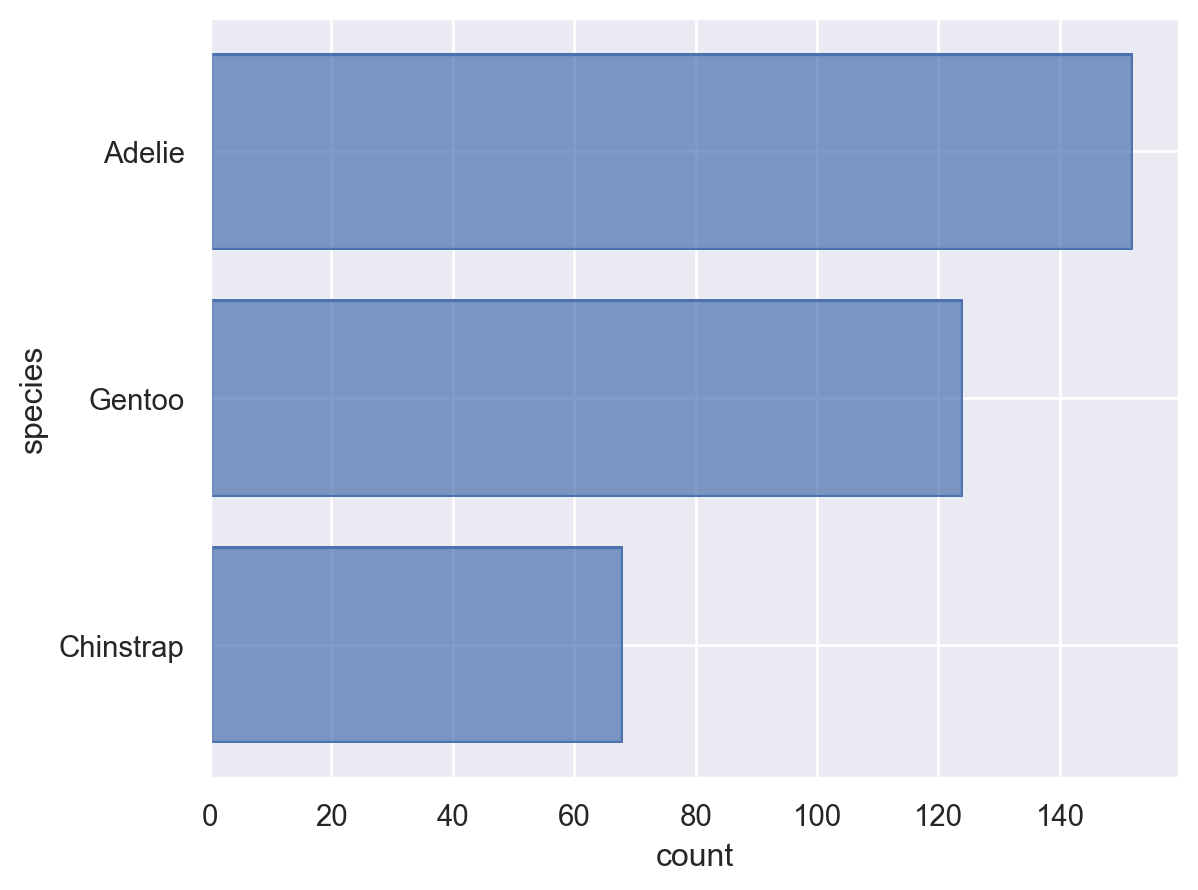

In [21]:
so.Plot(
    penguins[op.count("species"), op.sort("count")].data,
    x="count",
    y="species",
).add(so.Bar())